# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Install and Load Libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 146 kB 45.1 MB/s 
     |████████████████████████████████| 181 kB 47.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b51af226b68735d245688bfa9548bc1d71b4c81ac908a839d52872515e6bb598
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1.0 Training



## 1.0.2 Holdout Configuration

In [ ]:
# global variables

# ratio used to split train and validation data
val_size = 0.20
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val0 = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


13-07-2022 13:35:04 Downloading and reading train artifact
13-07-2022 13:35:05 Spliting data into train/val


In [ ]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val0.shape))

13-07-2022 13:35:05 x train: (25317, 16)
13-07-2022 13:35:05 y train: (25317,)
13-07-2022 13:35:05 x val: (6330, 16)
13-07-2022 13:35:05 y val: (6330,)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [ ]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

13-07-2022 13:35:06 Outlier Removal


In [ ]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

13-07-2022 13:35:06 x_train shape [original]: (25317, 16)
13-07-2022 13:35:06 x_train shape [outlier removal]: (24746, 16)


In [ ]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

## 1.1.2 Imbalanced Classification

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
df = pd.concat([x_train, y_train], axis=1)
df.y.value_counts()

no     21970
yes     2776
Name: y, dtype: int64

In [ ]:
def resaple_bal(x_train, y_train):
  # random_state=0 , (sampling_strategy="auto")
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.5)
  undersample = RandomUnderSampler(sampling_strategy="auto")
  X, y = oversample.fit_resample(x_train, y_train)
  X, y = undersample.fit_resample(X, y)
  return X, y


In [ ]:
x_train_bal, y_train_bal = resaple_bal( x_train, y_train)

In [ ]:
df_bal = pd.concat([x_train_bal, y_train_bal], axis=1)
df_bal.shape

(21970, 17)

In [ ]:
df_bal.y.value_counts()

no     10985
yes    10985
Name: y, dtype: int64

### 1.4.2 Encoding Target Variable

In [ ]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train_bal
y_train_bal = le.fit_transform(y_train_bal)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val0)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

13-07-2022 13:38:58 Encoding Target Variable
13-07-2022 13:38:58 Classes [0, 1]: ['no' 'yes']


### 1.4.5 Using a full-pipeline

#### 1.4.5.1 Feature Extractor

In [ ]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

In [ ]:
f_sel = copy_exception(x_train_bal.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      exceptions = ['default', 'loan']
      self.feature_names = copy_exception(feature_names, exceptions) 
      #self.feature_names = feature_names


    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,divorced,secondary,yes,unknown,may,unknown
1,unemployed,single,secondary,yes,cellular,jan,unknown
2,entrepreneur,single,tertiary,yes,cellular,apr,other
3,technician,divorced,tertiary,no,cellular,aug,unknown
4,technician,married,secondary,yes,unknown,may,unknown


In [ ]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,31,646,30,294,3,-1,0
1,29,12,29,298,3,-1,0
2,44,1136,3,345,2,249,7
3,52,0,19,119,2,-1,0
4,31,141,21,140,2,-1,0


#### 1.4.5.2 Handling Categorical Features

In [ ]:
x_train_bal.month.unique()

array(['may', 'jan', 'apr', 'aug', 'nov', 'jul', 'jun', 'feb', 'mar',
       'dec', 'oct', 'sep'], dtype=object)

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,divorced,secondary,yes,unknown,2st,unknown
1,other,single,secondary,yes,cellular,1st,unknown
2,entrepreneur,single,tertiary,yes,cellular,2st,unknown
3,technician,divorced,tertiary,no,cellular,3st,unknown
4,technician,married,secondary,yes,unknown,2st,unknown


In [ ]:
# check the cardinality before and after transformation
x_train_bal.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [ ]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.4.5.3 Handling Numerical Features

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ -0.91145982,  -0.29691523,   1.86946288, ...,   0.24804062,
        102.1128328 ,  -0.36523888],
       [ -1.09465064,  -0.52309301,   1.74222235, ...,   0.24804062,
        102.1128328 ,  -0.36523888],
       [  0.27928054,  -0.12210906,  -1.56603156, ...,  -0.14471271,
          2.08521333,   3.32579068],
       ...,
       [ -0.91145982,   4.05932587,  -1.43879103, ...,   0.24804062,
          0.4233864 ,   0.16205105],
       [ -0.36188734,  -0.46315946,  -0.16638568, ...,  -0.14471271,
          3.12129061,   0.68934099],
       [ -0.45348276,   0.80507714,   0.21533593, ...,   0.64079394,
        102.1128328 ,  -0.36523888]])

In [ ]:
df_num.shape

(24746, 7)

In [ ]:
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.4.5.4 Data Preparation Pipeline

In [ ]:
print(x_train_bal.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [ ]:
print(x_train_bal.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train_bal.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train_bal.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train_bal)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_failure,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,39.0,1601.0,23.0,201.0,2.0,10000.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,49.0,-1680.0,27.0,92.0,4.0,10000.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,35.0,3000.0,15.0,162.0,3.0,10000.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,36.0,556.0,7.0,35.0,3.0,10000.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,59.0,3180.0,6.0,28.0,1.0,10000.0,0.0


In [ ]:
print(df.columns.to_list())

['job_blue-collar', 'job_entrepreneur', 'job_other', 'job_pink-collar', 'job_self-employed', 'job_technician', 'job_white-collar', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_1st', 'month_2st', 'month_3st', 'month_4st', 'poutcome_failure', 'poutcome_success', 'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
print(new_data.shape)

(21970, 32)


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline
- le (label encoder object used to encode the target variable)

In [ ]:
#from sklearn.datasets import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import to_categorical
#import matplotlib.pyplot as plt



def nn_model():
	
  # define model
  model = Sequential()
  model.add(Dense(120, input_dim=32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(60, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt =  'adam'
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model



#   # fit model on train set
#   history = model.fit(train_x, train_y, epochs=100, verbose=0)

#   # evaluate model on test set
#   _, test_acc = model.evaluate(test_x, test_y, verbose=0)
#   return history, test_acc

In [ ]:
# The full pipeline 

from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',   # 'loss'             
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='auto', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

model = nn_model()

x_val_trans = full_pipeline_preprocessing.transform(x_val)

# training
logger.info("Training")
# fit model on train set
history = model.fit(new_data, y_train_bal,
                    epochs=100,
                    verbose=1,
                    #batch_size=512,
                    validation_data=(x_val_trans, y_val ),
                    callbacks=[early_stopping]
                    )

# evaluate model on test set
# _, test_acc = model.evaluate(test_x, test_y, verbose=0)

# predict
logger.info("Infering")
predict = model.predict(x_val_trans)

13-07-2022 14:19:03 Training


Epoch 1/100
687/687 [==============================] - 3s 3ms/step - loss: 25.4490 - accuracy: 0.6907 - val_loss: 23.3809 - val_accuracy: 0.3468
Epoch 2/100
687/687 [==============================] - 2s 3ms/step - loss: 16.5090 - accuracy: 0.7011 - val_loss: 4.6738 - val_accuracy: 0.8791
Epoch 3/100
687/687 [==============================] - 2s 3ms/step - loss: 11.8081 - accuracy: 0.7155 - val_loss: 39.0606 - val_accuracy: 0.3638
Epoch 4/100
687/687 [==============================] - 2s 3ms/step - loss: 15.3359 - accuracy: 0.7190 - val_loss: 21.6065 - val_accuracy: 0.5141
Epoch 5/100
687/687 [==============================] - 2s 3ms/step - loss: 10.9662 - accuracy: 0.7274 - val_loss: 9.1028 - val_accuracy: 0.8703
Epoch 6/100
687/687 [==============================] - 2s 3ms/step - loss: 11.0756 - accuracy: 0.7341 - val_loss: 9.6161 - val_accuracy: 0.7479
Epoch 7/100
687/687 [==============================] - 2s 3ms/step - loss: 11.7613 - accuracy: 0.7330 - val_loss: 13.9524 - val_accur

13-07-2022 14:19:41 Infering


In [ ]:
# Evaluation Metrics
y_pred = np.rint(predict)

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

13-07-2022 14:15:56 Evaluation metrics
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
13-07-2022 14:15:56 Accuracy: 0.6977883096366508
13-07-2022 14:15:56 Precision: 0.2607099143206854
13-07-2022 14:15:56 Recall: 0.8635135135135135
13-07-2022 14:15:56 F1: 0.4005014102162331
13-07-2022 14:15:56 G-Mean: 0.7639406890564698


In [ ]:
model.summary() # mostra modelo

model.evaluate(testX, testY_one_hot)[1]

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
clf.get_params().keys()

dict_keys(['epochs', 'batch_size', 'verbose', 'callbacks', 'build_fn'])

In [ ]:
print(predict)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
dt6_score_train = pipe.score(x_train_bal, y_train_bal)
print("Training score: ",dt6_score_train)
dt6_score_test = pipe.score(x_val, y_val)
print("Testing score: ",dt6_score_test)

Training score:  0.8504024723300273
Testing score:  0.8006319115323854


In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train_bal)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train_bal, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train_bal, predict_bias, zero_division=1)
recall = recall_score(y_train_bal, predict_bias, zero_division=1)
acc = accuracy_score(y_train_bal, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

09-07-2022 00:45:25 Infering Bias
09-07-2022 00:45:25 Bias Evaluation metrics
09-07-2022 00:45:25 Bias Accuracy: 0.8504024723300273
09-07-2022 00:45:25 Bias Precision: 0.8196639965974339
09-07-2022 00:45:25 Bias Recall: 0.8771810043999393
09-07-2022 00:45:25 Bias F1: 0.847447689545238


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.96      0.80      0.88      5590
           1       0.34      0.77      0.48       740

    accuracy                           0.80      6330
   macro avg       0.65      0.79      0.68      6330
weighted avg       0.89      0.80      0.83      6330



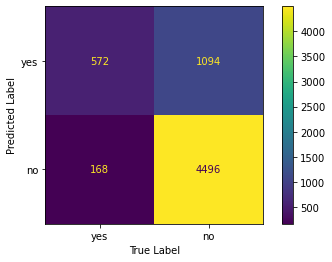

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

09-07-2022 00:45:40 Uploading figures


In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.67208590e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.11056615e-04, 1.92732335e-03, 1.18088130e-03,
       0.00000000e+00, 0.00000000e+00, 1.05033598e-01, 1.09270480e-01,
       3.64153312e-03, 1.30219382e-02, 2.37732211e-03, 2.13052484e-02,
       1.37494237e-02, 7.75081245e-04, 6.19561826e-03, 1.29949800e-01,
       0.00000000e+00, 1.50315505e-03, 5.69954663e-03, 1.37002972e-03,
       5.26693584e-01, 2.31628817e-02, 3.07022254e-02, 1.46206397e-03])

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'housing_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'housing_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train_bal, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train_bal),
#                                    y_train_bal,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

Acc,0.80063
F1,0.47548
Precision,0.34334
Recall,0.77297


## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 41

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
            },
        "max_depth": {
            "values": [5, 7, 9]
            },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="bank_mlp", entity="mlops_ivan")

Create sweep with ID: xt3jzbdg
Sweep URL: https://wandb.ai/mlops_ivan/decision_tree_bank/sweeps/xt3jzbdg


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__max_depth": run.config.max_depth})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train_bal, y_train_bal)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=24)

wandb: Agent Starting Run: e36g2kp6 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 9
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:47:25 Training
09-07-2022 00:47:25 Infering
09-07-2022 00:47:25 Evaluation metrics
09-07-2022 00:47:25 Accuracy: 0.8232227488151659
09-07-2022 00:47:25 Precision: 0.3745863666446062
09-07-2022 00:47:25 Recall: 0.7648648648648648
09-07-2022 00:47:25 F1: 0.5028876055086628


Accuracy,0.82322
F1,0.50289
Precision,0.37459
Recall,0.76486


wandb: Agent Starting Run: hibd882f with config:
wandb: 	criterion: gini
wandb: 	max_depth: 9
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:47:35 Training
09-07-2022 00:47:35 Infering
09-07-2022 00:47:36 Evaluation metrics
09-07-2022 00:47:36 Accuracy: 0.8003159557661927
09-07-2022 00:47:36 Precision: 0.34441805225653205
09-07-2022 00:47:36 Recall: 0.7837837837837838
09-07-2022 00:47:36 F1: 0.47854785478547857


Accuracy,0.80032
F1,0.47855
Precision,0.34442
Recall,0.78378


wandb: Agent Starting Run: szb7tuhb with config:
wandb: 	criterion: gini
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:47:45 Training
09-07-2022 00:47:46 Infering
09-07-2022 00:47:46 Evaluation metrics
09-07-2022 00:47:46 Accuracy: 0.8361769352290679
09-07-2022 00:47:46 Precision: 0.3927797833935018
09-07-2022 00:47:46 Recall: 0.7351351351351352
09-07-2022 00:47:46 F1: 0.5119999999999999


Accuracy,0.83618
F1,0.512
Precision,0.39278
Recall,0.73514


wandb: Agent Starting Run: 4635zkg5 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:47:56 Training
09-07-2022 00:47:56 Infering
09-07-2022 00:47:56 Evaluation metrics
09-07-2022 00:47:56 Accuracy: 0.8308056872037914
09-07-2022 00:47:56 Precision: 0.3853083853083853
09-07-2022 00:47:56 Recall: 0.7513513513513513
09-07-2022 00:47:56 F1: 0.5093907466788822


Accuracy,0.83081
F1,0.50939
Precision,0.38531
Recall,0.75135


wandb: Agent Starting Run: 00uarfwu with config:
wandb: 	criterion: gini
wandb: 	max_depth: 7
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:06 Training
09-07-2022 00:48:07 Infering
09-07-2022 00:48:07 Evaluation metrics
09-07-2022 00:48:07 Accuracy: 0.8360189573459715
09-07-2022 00:48:07 Precision: 0.3924963924963925
09-07-2022 00:48:07 Recall: 0.7351351351351352
09-07-2022 00:48:07 F1: 0.5117591721542805


Accuracy,0.83602
F1,0.51176
Precision,0.3925
Recall,0.73514


wandb: Agent Starting Run: v78g9qop with config:
wandb: 	criterion: gini
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:16 Training
09-07-2022 00:48:17 Infering
09-07-2022 00:48:17 Evaluation metrics
09-07-2022 00:48:17 Accuracy: 0.8361769352290679
09-07-2022 00:48:17 Precision: 0.3927797833935018
09-07-2022 00:48:17 Recall: 0.7351351351351352
09-07-2022 00:48:17 F1: 0.5119999999999999


Accuracy,0.83618
F1,0.512
Precision,0.39278
Recall,0.73514


wandb: Agent Starting Run: xu9doaew with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:27 Training
09-07-2022 00:48:27 Infering
09-07-2022 00:48:27 Evaluation metrics
09-07-2022 00:48:27 Accuracy: 0.7933649289099526
09-07-2022 00:48:27 Precision: 0.33640552995391704
09-07-2022 00:48:27 Recall: 0.7891891891891892
09-07-2022 00:48:27 F1: 0.4717285945072697


Accuracy,0.79336
F1,0.47173
Precision,0.33641
Recall,0.78919


wandb: Agent Starting Run: y8puj4zw with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:37 Training
09-07-2022 00:48:38 Infering
09-07-2022 00:48:38 Evaluation metrics
09-07-2022 00:48:38 Accuracy: 0.7930489731437599
09-07-2022 00:48:38 Precision: 0.33751425313568983
09-07-2022 00:48:38 Recall: 0.8
09-07-2022 00:48:38 F1: 0.4747393744987971


Accuracy,0.79305
F1,0.47474
Precision,0.33751
Recall,0.8


wandb: Agent Starting Run: gn462mqf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 9
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:47 Training
09-07-2022 00:48:48 Infering
09-07-2022 00:48:48 Evaluation metrics
09-07-2022 00:48:48 Accuracy: 0.8273301737756714
09-07-2022 00:48:48 Precision: 0.38033898305084746
09-07-2022 00:48:48 Recall: 0.7581081081081081
09-07-2022 00:48:48 F1: 0.5065462753950338


Accuracy,0.82733
F1,0.50655
Precision,0.38034
Recall,0.75811


wandb: Agent Starting Run: r5k3tfo8 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:48:58 Training
09-07-2022 00:48:58 Infering
09-07-2022 00:48:58 Evaluation metrics
09-07-2022 00:48:58 Accuracy: 0.7930489731437599
09-07-2022 00:48:58 Precision: 0.33751425313568983
09-07-2022 00:48:58 Recall: 0.8
09-07-2022 00:48:58 F1: 0.4747393744987971


Accuracy,0.79305
F1,0.47474
Precision,0.33751
Recall,0.8


wandb: Agent Starting Run: 1qnfd6te with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 9
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:49:08 Training
09-07-2022 00:49:08 Infering
09-07-2022 00:49:09 Evaluation metrics
09-07-2022 00:49:09 Accuracy: 0.8260663507109005
09-07-2022 00:49:09 Precision: 0.37877770315648085
09-07-2022 00:49:09 Recall: 0.7621621621621621
09-07-2022 00:49:09 F1: 0.506056527590848


Accuracy,0.82607
F1,0.50606
Precision,0.37878
Recall,0.76216


wandb: Agent Starting Run: 22hmk6rw with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 9
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:49:18 Training
09-07-2022 00:49:19 Infering
09-07-2022 00:49:19 Evaluation metrics
09-07-2022 00:49:19 Accuracy: 0.8260663507109005
09-07-2022 00:49:19 Precision: 0.37877770315648085
09-07-2022 00:49:19 Recall: 0.7621621621621621
09-07-2022 00:49:19 F1: 0.506056527590848


Accuracy,0.82607
F1,0.50606
Precision,0.37878
Recall,0.76216


wandb: Agent Starting Run: me7o5ayf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:49:29 Training
09-07-2022 00:49:29 Infering
09-07-2022 00:49:29 Evaluation metrics
09-07-2022 00:49:29 Accuracy: 0.8480252764612954
09-07-2022 00:49:29 Precision: 0.4138198757763975
09-07-2022 00:49:29 Recall: 0.7202702702702702
09-07-2022 00:49:29 F1: 0.5256410256410257


Accuracy,0.84803
F1,0.52564
Precision,0.41382
Recall,0.72027


wandb: Agent Starting Run: ipibncpo with config:
wandb: 	criterion: gini
wandb: 	max_depth: 9
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:49:39 Training
09-07-2022 00:49:39 Infering
09-07-2022 00:49:39 Evaluation metrics
09-07-2022 00:49:39 Accuracy: 0.8003159557661927
09-07-2022 00:49:39 Precision: 0.34441805225653205
09-07-2022 00:49:39 Recall: 0.7837837837837838
09-07-2022 00:49:39 F1: 0.47854785478547857


Accuracy,0.80032
F1,0.47855
Precision,0.34442
Recall,0.78378


wandb: Agent Starting Run: 0bm9v4e4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:49:49 Training
09-07-2022 00:49:50 Infering
09-07-2022 00:49:50 Evaluation metrics
09-07-2022 00:49:50 Accuracy: 0.8480252764612954
09-07-2022 00:49:50 Precision: 0.4138198757763975
09-07-2022 00:49:50 Recall: 0.7202702702702702
09-07-2022 00:49:50 F1: 0.5256410256410257


Accuracy,0.84803
F1,0.52564
Precision,0.41382
Recall,0.72027


wandb: Agent Starting Run: d9rdq2n4 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:50:00 Training
09-07-2022 00:50:00 Infering
09-07-2022 00:50:00 Evaluation metrics
09-07-2022 00:50:00 Accuracy: 0.8308056872037914
09-07-2022 00:50:00 Precision: 0.3853083853083853
09-07-2022 00:50:00 Recall: 0.7513513513513513
09-07-2022 00:50:00 F1: 0.5093907466788822


Accuracy,0.83081
F1,0.50939
Precision,0.38531
Recall,0.75135


wandb: Agent Starting Run: pznx1epy with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 9
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:50:10 Training
09-07-2022 00:50:11 Infering
09-07-2022 00:50:11 Evaluation metrics
09-07-2022 00:50:11 Accuracy: 0.8271721958925751
09-07-2022 00:50:11 Precision: 0.38024357239512857
09-07-2022 00:50:11 Recall: 0.7594594594594595
09-07-2022 00:50:11 F1: 0.5067628494138864


Accuracy,0.82717
F1,0.50676
Precision,0.38024
Recall,0.75946


wandb: Agent Starting Run: 5dw39tsr with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:50:21 Training
09-07-2022 00:50:21 Infering
09-07-2022 00:50:21 Evaluation metrics
09-07-2022 00:50:21 Accuracy: 0.8036334913112164
09-07-2022 00:50:21 Precision: 0.34840265220012057
09-07-2022 00:50:21 Recall: 0.7810810810810811
09-07-2022 00:50:21 F1: 0.48186744476865373


Accuracy,0.80363
F1,0.48187
Precision,0.3484
Recall,0.78108


wandb: Agent Starting Run: zafmrjz1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 9
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:50:31 Training
09-07-2022 00:50:31 Infering
09-07-2022 00:50:31 Evaluation metrics
09-07-2022 00:50:31 Accuracy: 0.8271721958925751
09-07-2022 00:50:31 Precision: 0.38024357239512857
09-07-2022 00:50:31 Recall: 0.7594594594594595
09-07-2022 00:50:31 F1: 0.5067628494138864


Accuracy,0.82717
F1,0.50676
Precision,0.38024
Recall,0.75946


wandb: Agent Starting Run: njhhnxm2 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 7
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:50:41 Training
09-07-2022 00:50:42 Infering
09-07-2022 00:50:42 Evaluation metrics
09-07-2022 00:50:42 Accuracy: 0.8097946287519747
09-07-2022 00:50:42 Precision: 0.35353535353535354
09-07-2022 00:50:42 Recall: 0.7567567567567568
09-07-2022 00:50:42 F1: 0.4819277108433735


Accuracy,0.80979
F1,0.48193
Precision,0.35354
Recall,0.75676


wandb: Agent Starting Run: quhioqku with config:
wandb: 	criterion: gini
wandb: 	max_depth: 9
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


09-07-2022 00:50:52 Training
09-07-2022 00:50:52 Infering
09-07-2022 00:50:52 Evaluation metrics
09-07-2022 00:50:52 Accuracy: 0.8003159557661927
09-07-2022 00:50:52 Precision: 0.34441805225653205
09-07-2022 00:50:52 Recall: 0.7837837837837838
09-07-2022 00:50:52 F1: 0.47854785478547857


Accuracy,0.80032
F1,0.47855
Precision,0.34442
Recall,0.78378


wandb: Agent Starting Run: otx3g2hc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:51:02 Training
09-07-2022 00:51:03 Infering
09-07-2022 00:51:03 Evaluation metrics
09-07-2022 00:51:03 Accuracy: 0.7933649289099526
09-07-2022 00:51:03 Precision: 0.33640552995391704
09-07-2022 00:51:03 Recall: 0.7891891891891892
09-07-2022 00:51:03 F1: 0.4717285945072697


Accuracy,0.79336
F1,0.47173
Precision,0.33641
Recall,0.78919


wandb: Agent Starting Run: 0gdef1ls with config:
wandb: 	criterion: gini
wandb: 	max_depth: 9
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:51:12 Training
09-07-2022 00:51:13 Infering
09-07-2022 00:51:13 Evaluation metrics
09-07-2022 00:51:13 Accuracy: 0.8232227488151659
09-07-2022 00:51:13 Precision: 0.3745863666446062
09-07-2022 00:51:13 Recall: 0.7648648648648648
09-07-2022 00:51:13 F1: 0.5028876055086628


Accuracy,0.82322
F1,0.50289
Precision,0.37459
Recall,0.76486


wandb: Agent Starting Run: kp3fzqng with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


09-07-2022 00:51:23 Training
09-07-2022 00:51:23 Infering
09-07-2022 00:51:23 Evaluation metrics
09-07-2022 00:51:23 Accuracy: 0.7933649289099526
09-07-2022 00:51:23 Precision: 0.33640552995391704
09-07-2022 00:51:23 Recall: 0.7891891891891892
09-07-2022 00:51:23 F1: 0.4717285945072697


Accuracy,0.79336
F1,0.47173
Precision,0.33641
Recall,0.78919


## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
# pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
# pipe.set_params(**{"classifier__criterion": 'entropy'})
# pipe.set_params(**{"classifier__splitter": 'random'})
# pipe.set_params(**{"classifier__max_depth": 6})
# pipe.set_params(**{"classifier__random_state": 41})

pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__class_weight": {0:1.0, 1:6.0}})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train_bal, y_train_bal)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

11-07-2022 00:59:57 Training
11-07-2022 00:59:57 Infering
11-07-2022 00:59:57 Evaluation metrics
11-07-2022 00:59:57 Accuracy: 0.8429699842022117
11-07-2022 00:59:57 Precision: 0.407703488372093
11-07-2022 00:59:57 Recall: 0.7581081081081081
11-07-2022 00:59:57 F1: 0.5302457466918714


In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

11-07-2022 01:00:57 Dumping the artifacts to disk


['target_encoder']

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

11-07-2022 01:00:59 Logging model artifact


In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

11-07-2022 01:01:02 Logging target enconder artifact


In [ ]:
run.finish()

Acc,0.84297
F1,0.53025
Precision,0.4077
Recall,0.75811


# 2.0 Test evaluation

## 2.1 Evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

02-06-2022 13:29:40 Downloading and reading test artifact
02-06-2022 13:29:41 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [ ]:
# Take a look at the target variable
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

02-06-2022 13:29:41 Extracting the encoding of the target variable


In [ ]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

02-06-2022 13:29:42 Classes [0, 1]: ['no' 'yes']


In [ ]:
# target variable after the encoding
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

02-06-2022 13:29:50 Downloading and load the exported model


In [ ]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

02-06-2022 13:29:53 Infering
02-06-2022 13:29:53 Test Evaluation metrics
02-06-2022 13:29:53 Test Accuracy: 0.8961220878796815
02-06-2022 13:29:53 Test Precision: 0.6578014184397163
02-06-2022 13:29:53 Test Recall: 0.23377441713925645
02-06-2022 13:29:53 Test F1: 0.3449558344955834


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.66      0.23      0.34      1587

    accuracy                           0.90     13564
   macro avg       0.78      0.61      0.64     13564
weighted avg       0.88      0.90      0.87     13564



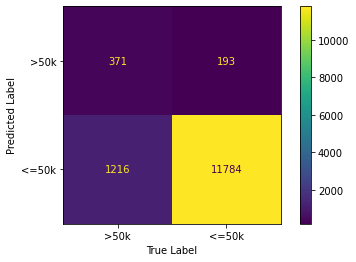

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

02-06-2022 13:30:02 Uploading figures


In [ ]:
run.finish()

Acc,0.89612
F1,0.34496
Precision,0.6578
Recall,0.23377
